# Logistic Regression

## Librerías

In [1]:
# Librerias necesarias
import os

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':40,
         'ytick.labelsize': 40
}
plt.rcParams.update(params)
# Seaborn conf
import seaborn as sns
sns.set(style='darkgrid')
sns.set_palette(sns.color_palette("Blues"))

import sys

#Procesado de datos
import pandas as pd
import numpy as np
import operator

#Modelos
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')


from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from nltk import ngrams

from keras.layers import Dense, Embedding, Flatten, GlobalMaxPool1D, Dropout
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from tensorflow.keras import regularizers

from keras.initializers import Constant

from wordcloud import WordCloud

from sklearn.decomposition import TruncatedSVD
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
import tensorflow as tf

from sklearn import preprocessing
from nltk import ngrams
from sklearn.linear_model import LogisticRegression

2024-04-23 13:11:03.805115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 13:11:03.805157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 13:11:03.806074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 13:11:03.811442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 13:11:04.378027: W tensorflow/compiler/tf2

## Carga de conjunto de datos

In [2]:
df_training = pd.read_csv("./data/ds_training_processed.csv")
df_testing = pd.read_csv("./data/ds_testing_processed.csv")

X_train = df_training["text"]
y_train = df_training["sentiment"]
X_test = df_testing["text"]
y_test = df_testing["sentiment"]

y_train_2 = to_categorical(y_train, num_classes=2)
y_test_2 = to_categorical(y_test, num_classes=2)

## Carga de modelos de representación

In [3]:
def load_representation_model(file_name, include_embedding_matrix=False):
    res = {}
    with open("./repmodels/"+file_name+".txt", 'r') as d:
        res["model"] = d.readline()
    res["train_text_features"] = np.load("./repmodels/"+file_name+"_train.npy")
    res["test_text_features"] = np.load("./repmodels/"+file_name+"_test.npy")

    if include_embedding_matrix:
        res["embedding_matrix"] = np.load("./repmodels/"+file_name+"_embeddingmatrix.npy")

    return res

vsm_binary = load_representation_model("vsm_binary")
vsm_binary_ngrams = load_representation_model("vsm_binary_ngrams")
vsm_tfidf = load_representation_model("vsm_tfidf")
vsm_tfidf_ngrams = load_representation_model("vsm_tfidf_ngrams")
embedding_padding = load_representation_model("embedding_padding")
embedding_glove = load_representation_model("embedding_glove")

## Funciones generales

In [5]:
pd.set_option('display.max_colwidth', 2000)
results = []
def add_to_results(classifier, dskind, predict_x, y_test):
    y_pred = np.argmax(predict_x,axis=1)

    results.append({"classifier": classifier,
                    "dataset": dskind,
                    "accuracy": accuracy_score(y_test, y_pred)
                    })
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on")
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

def train_and_evaluate_classifier(X, yt, estimator, grid, title):
    # Se realiza validación cruzada sobre el clasificador seleccionado
    from sklearn.model_selection import ShuffleSplit
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    from sklearn.model_selection import GridSearchCV
    classifier = GridSearchCV(estimator=estimator, cv=cv,  param_grid=grid, error_score=0.0, n_jobs = -1, verbose = 5)

    # Entrenamiento
    print("Training model")
    classifier.fit(X, yt)

    # Puntuación de la validación cruzada
    from sklearn.model_selection import cross_val_score
    print("CV-scores for each grid configuration")
    means = classifier.cv_results_['mean_test_score']
    stds = classifier.cv_results_['std_test_score']
    for mean, std, params in sorted(zip(means, stds, classifier.cv_results_['params']), key=lambda x: -x[0]):
        print("Accuracy: %0.3f (+/-%0.03f) for params: %r" % (mean, std * 2, params))
    print()

    # Curva de aprendizaje
    print("Learning curve for the best estimator")
    title = title + ' (Learning Curves)'
    plot_learning_curve(classifier.best_estimator_, title, X, yt, cv=cv)
    plt.show()

    return classifier


def print_classification_report(predictions, testing):
    print("Classification Report")
    print(classification_report(testing, predictions, target_names=["negative","positive"]))
    cm = confusion_matrix(y_true=testing,  y_pred=predictions)

    plot_confusion_matrix(cm, classes=["negative","positive"])

    print("Final Accuracy")
    print(accuracy_score(testing, predictions))

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'bo', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel("Epochs")
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def join_csv_for_experiment(experiment_string, number_of_experiements):
    experiments_data = []
    for i in range(1, number_of_experiements+1):
        experiments_data.append( pd.read_csv("exp_"+experiment_string+"_"+str(i)+".csv") )

    res = pd.concat(experiments_data, ignore_index=True)
    res.to_csv("exp_"+experiment_string+".csv")

## Clasificadores

Training model
Fitting 5 folds for each of 14 candidates, totalling 70 fits


/home/david/miniconda3/envs/UNED/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/david/miniconda3/envs/UNED/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

CV-scores for each grid configuration
Accuracy: 0.928 (+/-0.008) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.920 (+/-0.012) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.914 (+/-0.010) for params: {'C': 100, 'penalty': 'l2'}
Accuracy: 0.909 (+/-0.012) for params: {'C': 1000, 'penalty': 'l2'}
Accuracy: 0.887 (+/-0.007) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.856 (+/-0.018) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: 0.755 (+/-0.214) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: 0.000 (+/-0.000) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.000 (+/-0.000) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.000 (+/-0.000) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.000 (+/-0.000) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.000 (+/-0.000) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.000 (+/-0.000) for params: {'C': 100, 'penalty': 'l1'}
Accuracy: 0.000 (+/-0.000) for params: {'C': 1000, 'penalty': 'l1'}

Learning curve for th

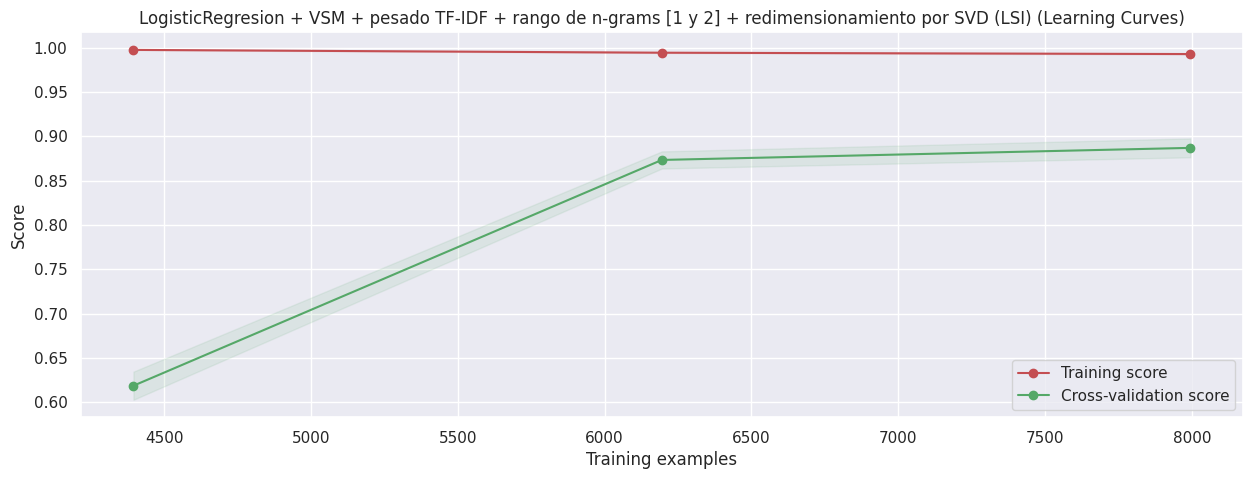

Best estimator found by grid search:
LogisticRegression(C=10)


[CV 5/5] END ...............C=0.001, penalty=l2;, score=0.861 total time=   4.3s
[CV 2/5] END ...................C=1, penalty=l2;, score=0.918 total time=  29.4s
[CV 1/5] END ................C=0.01, penalty=l2;, score=0.859 total time=   4.4s
[CV 4/5] END ...................C=1, penalty=l2;, score=0.925 total time=  30.1s
[CV 2/5] END ...............C=0.001, penalty=l2;, score=0.675 total time=   4.0s
[CV 4/5] END ...................C=1, penalty=l1;, score=0.000 total time=   1.1s
[CV 1/5] END ..................C=10, penalty=l1;, score=0.000 total time=   1.2s
[CV 3/5] END ..................C=10, penalty=l2;, score=0.922 total time=  29.4s
[CV 4/5] END ...............C=0.001, penalty=l1;, score=0.000 total time=   1.0s
[CV 1/5] END .................C=0.1, penalty=l2;, score=0.888 total time=  11.5s
[CV 4/5] END .................C=100, penalty=l2;, score=0.917 total time=  38.8s
[CV 4/5] END ................C=0.01, penalty=l1;, score=0.000 total time=   1.0s
[CV 4/5] END ...............

In [6]:

# vsm_binary = load_representation_model("vsm_binary")
# vsm_binary_ngrams = load_representation_model("vsm_binary_ngrams")
# vsm_tfidf = load_representation_model("vsm_tfidf")
# vsm_tfidf_ngrams = load_representation_model("vsm_tfidf_ngrams")

lr_grid= {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
lg_cls = train_and_evaluate_classifier(vsm_tfidf_ngrams["train_text_features"], 
                                        y_train, LogisticRegression(), 
                                        lr_grid, "LogisticRegresion + "+vsm_tfidf_ngrams["model"])
print("Best estimator found by grid search:")
print(lg_cls.best_estimator_)

Classification Report
              precision    recall  f1-score   support

    negative       0.86      0.91      0.89       999
    positive       0.90      0.85      0.88       998

    accuracy                           0.88      1997
   macro avg       0.88      0.88      0.88      1997
weighted avg       0.88      0.88      0.88      1997

Confusion matrix, without normalization


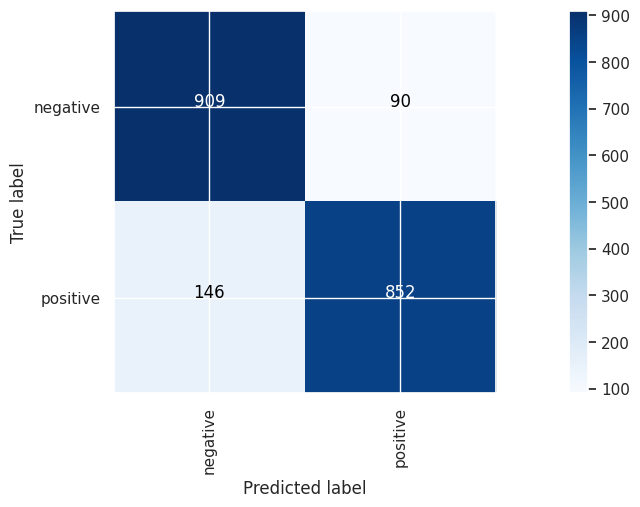

Final Accuracy
0.8818227341011518

--------------------------------------------------------------------------------------------------



In [7]:
# Se predice y se muestra los resultados
y_pred = lg_cls.predict(vsm_tfidf_ngrams["test_text_features"])
print_classification_report(y_pred, y_test)
print("\n--------------------------------------------------------------------------------------------------\n")